In [1]:
import acquire1
import prepare1
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import scipy as sp 
import os
from env import host, user, password
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import seaborn as sns
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

df = prepare1.zillow_prep()
df.head()

,id,parcelid,bathrooms,bedrooms,calculatedbathnbr,regionidcounty,zip_code,squarefootage,fips,fullbathcnt,lotsizesquarefeet,propertylandusedesc,transactiondate,taxamount,taxablevalue
0,2061546,11289917,2.0,3.0,2.0,3101.0,97318.0,1458.0,6037.0,2.0,8284.0,Single Family Residential,2017-06-23,2319.90,136104.0
1,1834372,11705026,1.0,2.0,1.0,3101.0,96018.0,1421.0,6037.0,1.0,6707.0,Single Family Residential,2017-06-30,543.69,35606.0
2,1923117,14269464,3.0,4.0,3.0,1286.0,96958.0,2541.0,6059.0,3.0,4975.0,Single Family Residential,2017-06-01,9819.72,880456.0
3,2121349,11389003,2.0,3.0,2.0,3101.0,96037.0,1650.0,6037.0,2.0,7300.0,Single Family Residential,2017-06-01,7673.19,614000.0
4,2093710,11967869,1.0,2.0,1.0,3101.0,96023.0,693.0,6037.0,1.0,2908.0,Single Family Residential,2017-06-29,3267.47,274237.0


In [2]:
df.drop(columns=['propertylandusedesc','id','parcelid','transactiondate','taxamount',
                'regionidcounty','zip_code','fips','fullbathcnt','lotsizesquarefeet','calculatedbathnbr'],inplace=True)
df.head()

,bathrooms,bedrooms,squarefootage,taxablevalue
0,2.0,3.0,1458.0,136104.0
1,1.0,2.0,1421.0,35606.0
2,3.0,4.0,2541.0,880456.0
3,2.0,3.0,1650.0,614000.0
4,1.0,2.0,693.0,274237.0


In [3]:
#Remove Outliers

#Q1 = np.quantile(df.taxablevalue,0.25)
#Q3 = np.quantile(df.taxablevalue,0.75)
#IQR = Q3 - Q1
#IQR

z_score = np.abs(stats.zscore(df))

df = df[(z_score < 3).all(axis=1)]
df.shape

(14411, 4)

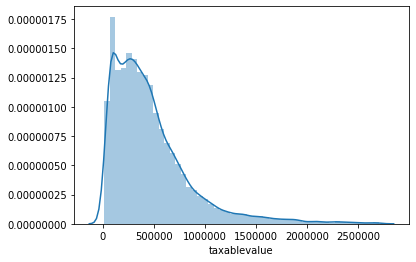

In [4]:
sns.distplot(df.taxablevalue)

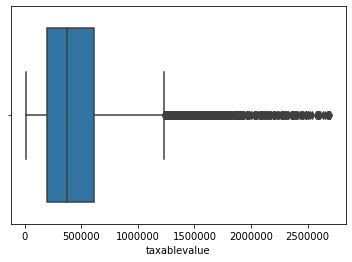

In [5]:
sns.boxplot(df.taxablevalue)

In [6]:
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)
print(train.shape, validate.shape, test.shape)

X_train = train.drop(columns=['taxablevalue'])
X_validate = validate.drop(columns=['taxablevalue'])
X_test = test.drop(columns=['taxablevalue'])

y_train = train[['taxablevalue']]
y_validate = validate[['taxablevalue']]
y_test = test[['taxablevalue']]

scaler = MinMaxScaler(copy=True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns.values).set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled,columns=X_validate.columns.values).set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns.values).set_index([X_test.index.values])

(8069, 4) (3459, 4) (2883, 4)


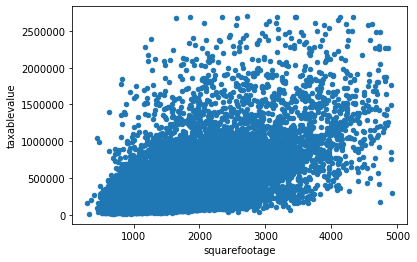

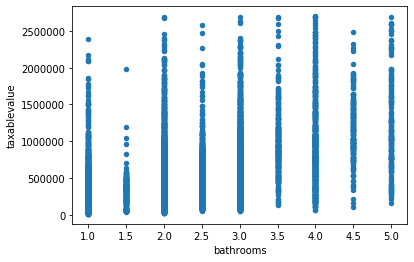

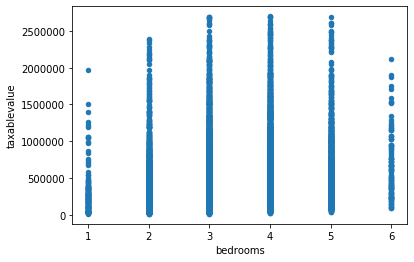

In [7]:
df.plot.scatter(y='taxablevalue', x='squarefootage')
df.plot.scatter(y='taxablevalue', x='bathrooms')
df.plot.scatter(y='taxablevalue', x='bedrooms')

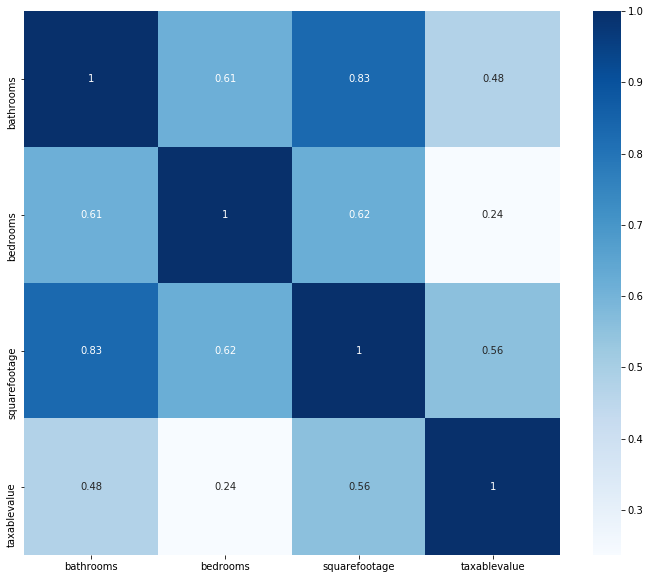

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(), annot=True, cmap='Blues')

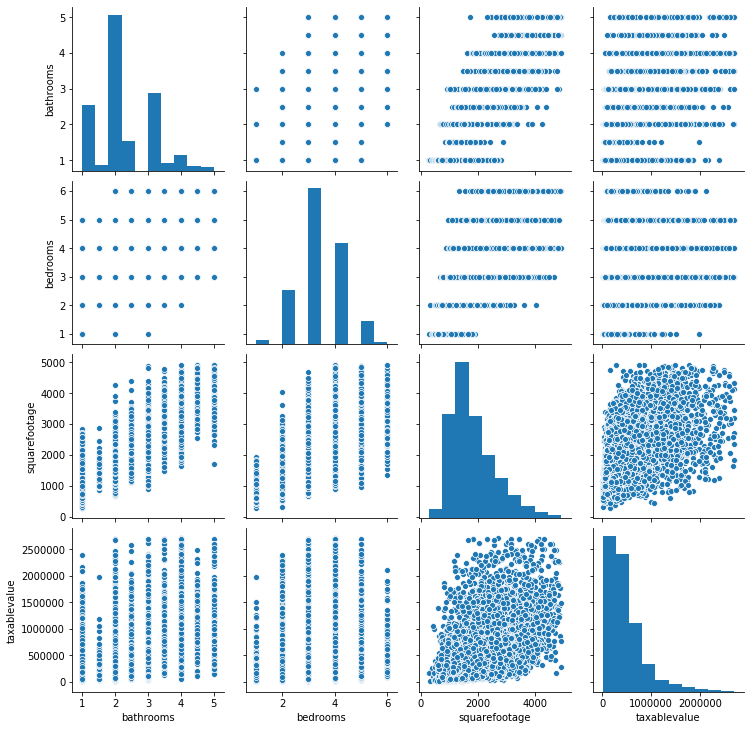

In [9]:
sns.pairplot(df)

Text(0.5, 1.0, 'taxablevalue')

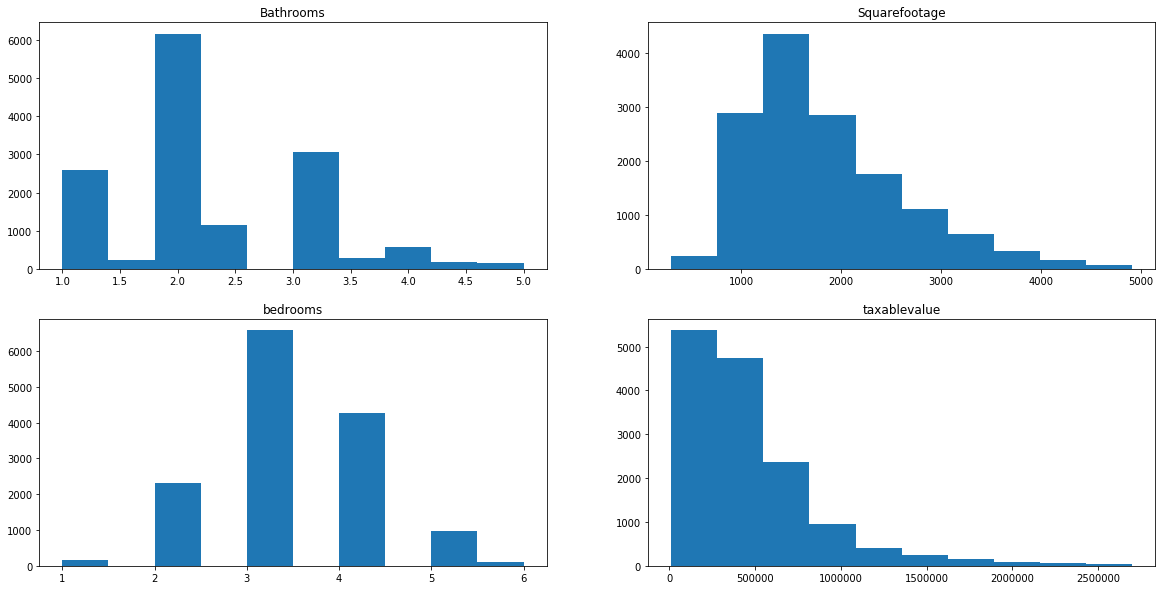

In [10]:
plt.subplots(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(df.bathrooms)
plt.title('Bathrooms')

plt.subplot(2,2,2);
plt.hist(df.squarefootage)
plt.title('Squarefootage')

plt.subplot(2,2,3);
plt.hist(df.bedrooms)
plt.title('bedrooms')

plt.subplot(2,2,4);
plt.hist(df.taxablevalue)
plt.title('taxablevalue')



# Statistical Testing
$Ho$: The taxable value is independant of the square footage.

$Ha$: There is a correlation with taxable value and square footage.

$a$: .05

We'll also see if bathrooms and bedrooms have a relationship with taxable value.

In [11]:
r, p = stats.pearsonr(df.taxablevalue,df.bathrooms)
print('taxablevalue v bathrooms')
print('p=', p)
print('r=', r, '\n')

print('taxablevalue v bedrooms')
r, p = stats.pearsonr(df.taxablevalue,df.bedrooms)
print('p=', p)
print('r=', r, '\n')

print('taxablevalue v squarefootage')
r, p = stats.pearsonr(df.taxablevalue,df.squarefootage)
print('p=', p)
print('r=', r)

taxablevalue v bathrooms
p= 0.0
r= 0.4802626196028511 

taxablevalue v bedrooms
p= 1.6825732104798927e-180
r= 0.2353068053372157 

taxablevalue v squarefootage
p= 0.0
r= 0.5570285148960232


The p is less than the alpha so we reject the $Ho$

In [12]:
# gotta put fips back in the dataframe

x1 = df[df.fips ==6037].taxablevalue

x2 = df[df.fips !=6037].taxablevalue


t, p = stats.ttest_ind(x1, x2)

t, p

AttributeError: 'DataFrame' object has no attribute 'fips'

# Modeling

We'll model the features all together then indivdually.


In [13]:
print('mean:',np.mean(y_train))
print('median:',np.median(y_train))

mean: taxablevalue    469041.007064
dtype: float64
median: 373752.0


In [14]:
baseline_rmse = mean_squared_error(y_train, np.full(y_train.shape, np.mean(y_train)))**.5
baseline_rmse
#baseline = np.mean(y_train)
#baseline

394666.6481900868

In [15]:
#make it
lm = LinearRegression(normalize=True)

#fit it
lm.fit(X_train_scaled, y_train)

#predict it
lm_pred = lm.predict(X_train_scaled)

#compute it
lm_mse = mean_squared_error(y_train, lm_pred)
lm_rmse = lm_mse**.5
lm_rmse

#make it
lars = LassoLars(alpha=0.1)

#fit it
lars.fit(X_train_scaled, y_train)

# predict our training observations
lars_pred = lars.predict(X_train_scaled)

# evaluate our training predictions
lars_mse = mean_squared_error(y_train, lars_pred)
lars_rmse = lars_mse**.5
lars_rmse

#make it
pf = PolynomialFeatures(degree=3)

#fit it
X_train_cubed = pf.fit_transform(X_train_scaled)

lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_train)

# predict our training observations (the cubed version)
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

# evaluate our predictions on training observations
lm_cubed_mse = mean_squared_error(y_train, lm_cubed_pred)
lm_cubed_rmse = lm_cubed_mse**.5

print('bedrooms, bathrooms, and squarefootage as features','\n')
print('The baseline is','               ',baseline_rmse.round(2))
print('The Linear Regression RMSE is',' ',lm_rmse.round(2))
print('The LassoLars RMSE is','         ',lars_rmse.round(2))
print('The PolynomialFeature RMSE is',' ',lm_cubed_rmse.round(2))

bedrooms, bathrooms, and squarefootage as features 

The baseline is                 394666.65
The Linear Regression RMSE is   321971.16
The LassoLars RMSE is           321971.16
The PolynomialFeature RMSE is   319435.48


In [16]:
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)
#print(train.shape, validate.shape, test.shape)

X_train = train.drop(columns=['taxablevalue','bedrooms'])
X_validate = validate.drop(columns=['taxablevalue','bedrooms'])
X_test = test.drop(columns=['taxablevalue','bedrooms'])

y_train = train[['taxablevalue']]
y_validate = validate[['taxablevalue']]
y_test = test[['taxablevalue']]

scaler = MinMaxScaler(copy=True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns.values).set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled,columns=X_validate.columns.values).set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns.values).set_index([X_test.index.values])


#make it
lm = LinearRegression(normalize=True)

#fit it
lm.fit(X_train_scaled, y_train)

#predict it
lm_pred = lm.predict(X_train_scaled)

#compute it
lm_mse = mean_squared_error(y_train, lm_pred)
lm_rmse = lm_mse**.5
lm_rmse

#make it
lars = LassoLars(alpha=0.1)

#fit it
lars.fit(X_train_scaled, y_train)

# predict our training observations
lars_pred = lars.predict(X_train_scaled)

# evaluate our training predictions
lars_mse = mean_squared_error(y_train, lars_pred)
lars_rmse = lars_mse**.5
lars_rmse

#make it
pf = PolynomialFeatures(degree=3)

#fit it
X_train_cubed = pf.fit_transform(X_train_scaled)

lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_train)

# predict our training observations (the cubed version)
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

# evaluate our predictions on training observations
lm_cubed_mse = mean_squared_error(y_train, lm_cubed_pred)
lm_cubed_rmse = lm_cubed_mse**.5

print('bathrooms, and squarefootage as features','\n')
print('The baseline is','               ',baseline_rmse.round(2))
print('The Linear Regression RMSE is',' ',lm_rmse.round(2))
print('The LassoLars RMSE is','         ',lars_rmse.round(2))
print('The PolynomialFeature RMSE is',' ',lm_cubed_rmse.round(2))

bathrooms, and squarefootage as features 

The baseline is                 394666.65
The Linear Regression RMSE is   327266.56
The LassoLars RMSE is           327266.56
The PolynomialFeature RMSE is   324359.95


In [17]:
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)
#print(train.shape, validate.shape, test.shape)

X_train = train.drop(columns=['taxablevalue','bedrooms','bathrooms'])
X_validate = validate.drop(columns=['taxablevalue','bedrooms','bathrooms'])
X_test = test.drop(columns=['taxablevalue','bedrooms','bathrooms'])

y_train = train[['taxablevalue']]
y_validate = validate[['taxablevalue']]
y_test = test[['taxablevalue']]

scaler = MinMaxScaler(copy=True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns.values).set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled,columns=X_validate.columns.values).set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns.values).set_index([X_test.index.values])


#make it
lm = LinearRegression(normalize=True)

#fit it
lm.fit(X_train_scaled, y_train)

#predict it
lm_pred = lm.predict(X_train_scaled)

#compute it
lm_mse = mean_squared_error(y_train, lm_pred)
lm_rmse = lm_mse**.5
lm_rmse

#make it
lars = LassoLars(alpha=0.1)

#fit it
lars.fit(X_train_scaled, y_train)

# predict our training observations
lars_pred = lars.predict(X_train_scaled)

# evaluate our training predictions
lars_mse = mean_squared_error(y_train, lars_pred)
lars_rmse = lars_mse**.5
lars_rmse

#make it
pf = PolynomialFeatures(degree=3)

#fit it
X_train_cubed = pf.fit_transform(X_train_scaled)

lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_train)

# predict our training observations (the cubed version)
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

# evaluate our predictions on training observations
lm_cubed_mse = mean_squared_error(y_train, lm_cubed_pred)
lm_cubed_rmse = lm_cubed_mse**.5

print('squarefootage as the only feature','\n')
print('The baseline is','               ',baseline_rmse.round(2))
print('The Linear Regression RMSE is',' ',lm_rmse.round(2))
print('The LassoLars RMSE is','         ',lars_rmse.round(2))
print('The PolynomialFeature RMSE is',' ',lm_cubed_rmse.round(2))

squarefootage as the only feature 

The baseline is                 394666.65
The Linear Regression RMSE is   327372.06
The LassoLars RMSE is           327372.06
The PolynomialFeature RMSE is   325529.06


# Validate

In [18]:
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)
#print(train.shape, validate.shape, test.shape)

X_train = train.drop(columns=['taxablevalue','bedrooms','bathrooms'])
X_validate = validate.drop(columns=['taxablevalue','bedrooms','bathrooms'])
X_test = test.drop(columns=['taxablevalue','bedrooms','bathrooms'])

y_train = train[['taxablevalue']]
y_validate = validate[['taxablevalue']]
y_test = test[['taxablevalue']]

scaler = MinMaxScaler(copy=True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns.values).set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled,columns=X_validate.columns.values).set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns.values).set_index([X_test.index.values])


#make it
lm = LinearRegression(normalize=True)

#fit it
lm.fit(X_validate_scaled, y_validate)

#predict it
lm_pred = lm.predict(X_validate_scaled)

#compute it
lm_mse = mean_squared_error(y_validate, lm_pred)
lm_rmse = lm_mse**.5
lm_rmse

#make it
lars = LassoLars(alpha=0.1)

#fit it
lars.fit(X_validate_scaled, y_validate)

# predict our training observations
lars_pred = lars.predict(X_validate_scaled)

# evaluate our training predictions
lars_mse = mean_squared_error(y_validate, lars_pred)
lars_rmse = lars_mse**.5
lars_rmse

#make it
pf = PolynomialFeatures(degree=3)

#fit it
X_train_cubed = pf.fit_transform(X_validate_scaled)

lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_validate)

# predict our training observations (the cubed version)
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

# evaluate our predictions on training observations
lm_cubed_mse = mean_squared_error(y_validate, lm_cubed_pred)
lm_cubed_rmse = lm_cubed_mse**.5

print('squarefootage as the only feature','\n')
print('The baseline is','               ',baseline_rmse.round(2))
print('The Linear Regression RMSE is',' ',lm_rmse.round(2))
print('The LassoLars RMSE is','         ',lars_rmse.round(2))
print('The PolynomialFeature RMSE is',' ',lm_cubed_rmse.round(2))

squarefootage as the only feature 

The baseline is                 394666.65
The Linear Regression RMSE is   316391.82
The LassoLars RMSE is           316391.82
The PolynomialFeature RMSE is   313363.11


In [19]:
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)
#print(train.shape, validate.shape, test.shape)

X_train = train.drop(columns=['taxablevalue','bedrooms','bathrooms'])
X_validate = validate.drop(columns=['taxablevalue','bedrooms','bathrooms'])
X_test = test.drop(columns=['taxablevalue','bedrooms','bathrooms'])

y_train = train[['taxablevalue']]
y_validate = validate[['taxablevalue']]
y_test = test[['taxablevalue']]

scaler = MinMaxScaler(copy=True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns.values).set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled,columns=X_validate.columns.values).set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns.values).set_index([X_test.index.values])


#make it
lm = LinearRegression(normalize=True)

#fit it
lm.fit(X_test_scaled, y_test)

#predict it
lm_pred = lm.predict(X_test_scaled)

#compute it
lm_mse = mean_squared_error(y_test, lm_pred)
lm_rmse = lm_mse**.5
lm_rmse

#make it
lars = LassoLars(alpha=0.1)

#fit it
lars.fit(X_test_scaled, y_test)

# predict our training observations
lars_pred = lars.predict(X_test_scaled)

# evaluate our training predictions
lars_mse = mean_squared_error(y_test, lars_pred)
lars_rmse = lars_mse**.5
lars_rmse

#make it
pf = PolynomialFeatures(degree=3)

#fit it
X_train_cubed = pf.fit_transform(X_test_scaled)

lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_test)

# predict our training observations (the cubed version)
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

# evaluate our predictions on training observations
lm_cubed_mse = mean_squared_error(y_test, lm_cubed_pred)
lm_cubed_rmse = lm_cubed_mse**.5

print('squarefootage as the only feature','\n')
print('The baseline is','               ',baseline_rmse.round(2))
print('The Linear Regression RMSE is',' ',lm_rmse.round(2))
print('The LassoLars RMSE is','         ',lars_rmse.round(2))
print('The PolynomialFeature RMSE is',' ',lm_cubed_rmse.round(2))

squarefootage as the only feature 

The baseline is                 394666.65
The Linear Regression RMSE is   336436.13
The LassoLars RMSE is           336436.13
The PolynomialFeature RMSE is   333888.44


# Feature engineering


In [20]:
df.head()

,bathrooms,bedrooms,squarefootage,taxablevalue
0,2.0,3.0,1458.0,136104.0
1,1.0,2.0,1421.0,35606.0
2,3.0,4.0,2541.0,880456.0
3,2.0,3.0,1650.0,614000.0
4,1.0,2.0,693.0,274237.0


In [21]:
fe = prepare1.zillow_prep()
fe.head()

,id,parcelid,bathrooms,bedrooms,calculatedbathnbr,regionidcounty,zip_code,squarefootage,fips,fullbathcnt,lotsizesquarefeet,propertylandusedesc,transactiondate,taxamount,taxablevalue
0,2061546,11289917,2.0,3.0,2.0,3101.0,97318.0,1458.0,6037.0,2.0,8284.0,Single Family Residential,2017-06-23,2319.90,136104.0
1,1834372,11705026,1.0,2.0,1.0,3101.0,96018.0,1421.0,6037.0,1.0,6707.0,Single Family Residential,2017-06-30,543.69,35606.0
2,1923117,14269464,3.0,4.0,3.0,1286.0,96958.0,2541.0,6059.0,3.0,4975.0,Single Family Residential,2017-06-01,9819.72,880456.0
3,2121349,11389003,2.0,3.0,2.0,3101.0,96037.0,1650.0,6037.0,2.0,7300.0,Single Family Residential,2017-06-01,7673.19,614000.0
4,2093710,11967869,1.0,2.0,1.0,3101.0,96023.0,693.0,6037.0,1.0,2908.0,Single Family Residential,2017-06-29,3267.47,274237.0


In [22]:
fe.zip_code.value_counts()

97319.0    224
97318.0    188
97329.0    169
97118.0    159
97328.0    147
          ... 
96039.0      1
96275.0      1
95996.0      1
96009.0      1
97119.0      1
Name: zip_code, Length: 373, dtype: int64

In [23]:
fe.fips.value_counts()

6037.0    9519
6059.0    4043
6111.0    1287
Name: fips, dtype: int64

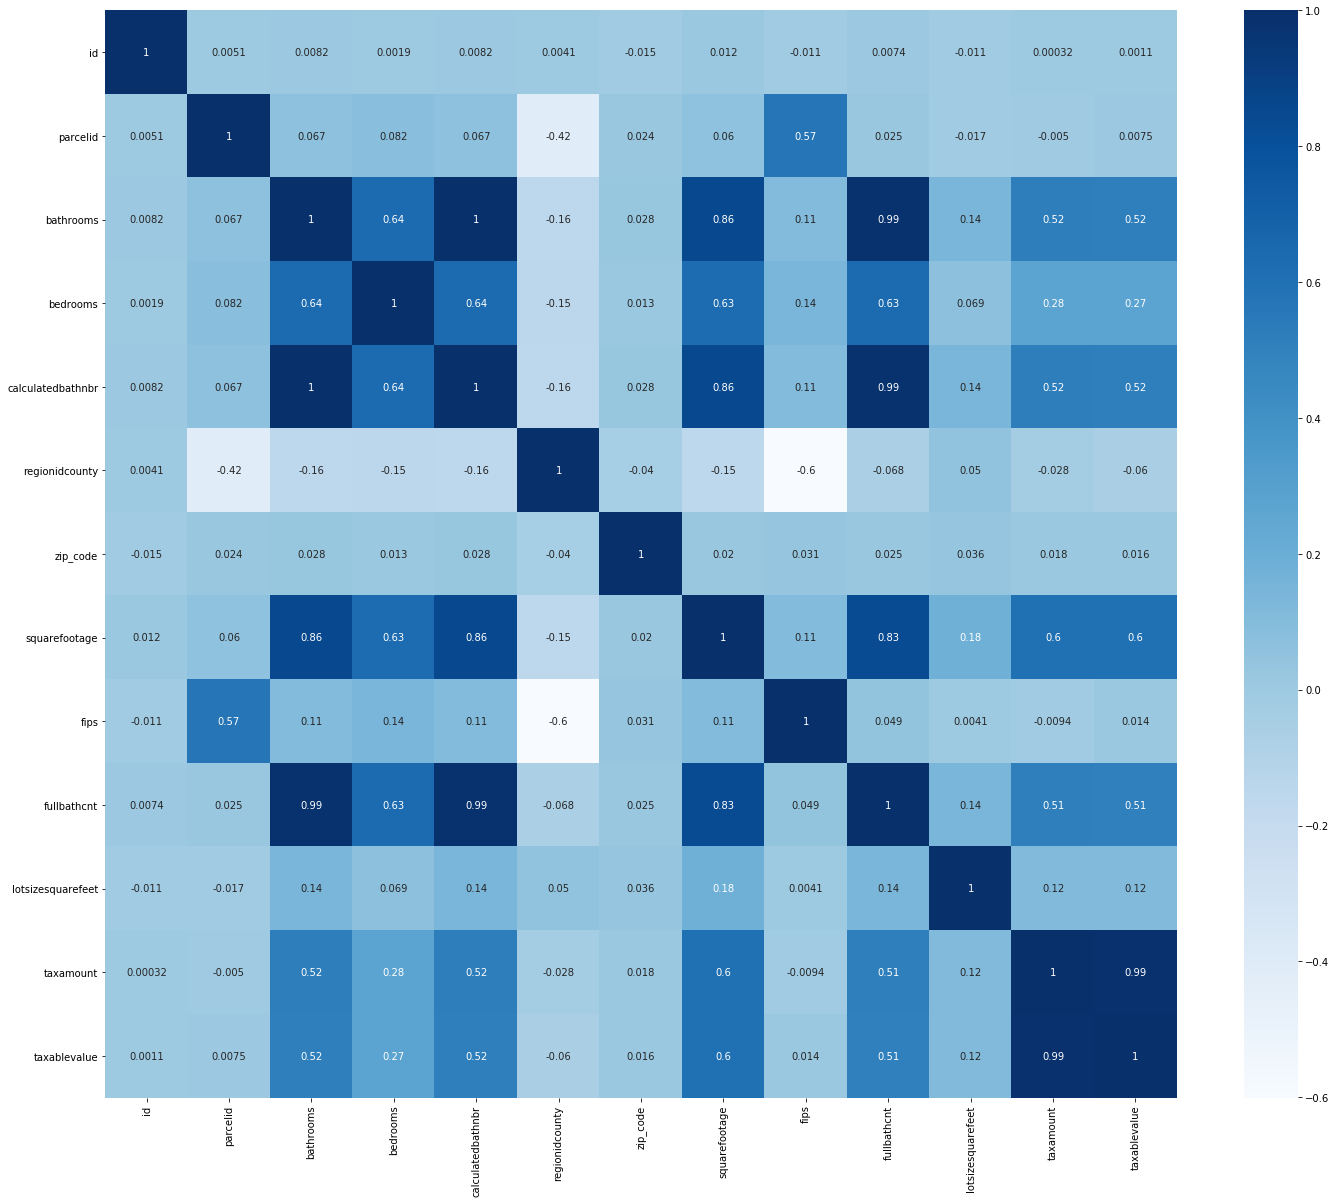

In [24]:
plt.figure(figsize=(24,20))
sns.heatmap(fe.corr(), annot=True, cmap='Blues')

In [25]:
fe['bath_sqft'] = fe.squarefootage / fe.bathrooms
fe['room_bath'] = fe.bedrooms / fe.bathrooms
fe.replace({6037:'la_county',
           6059:'orange_county',
           6111:'ventura_county'})
fe.head()

,id,parcelid,bathrooms,bedrooms,calculatedbathnbr,regionidcounty,zip_code,squarefootage,fips,fullbathcnt,lotsizesquarefeet,propertylandusedesc,transactiondate,taxamount,taxablevalue,bath_sqft,room_bath
0,2061546,11289917,2.0,3.0,2.0,3101.0,97318.0,1458.0,6037.0,2.0,8284.0,Single Family Residential,2017-06-23,2319.90,136104.0,729.0,1.500000
1,1834372,11705026,1.0,2.0,1.0,3101.0,96018.0,1421.0,6037.0,1.0,6707.0,Single Family Residential,2017-06-30,543.69,35606.0,1421.0,2.000000
2,1923117,14269464,3.0,4.0,3.0,1286.0,96958.0,2541.0,6059.0,3.0,4975.0,Single Family Residential,2017-06-01,9819.72,880456.0,847.0,1.333333
3,2121349,11389003,2.0,3.0,2.0,3101.0,96037.0,1650.0,6037.0,2.0,7300.0,Single Family Residential,2017-06-01,7673.19,614000.0,825.0,1.500000
4,2093710,11967869,1.0,2.0,1.0,3101.0,96023.0,693.0,6037.0,1.0,2908.0,Single Family Residential,2017-06-29,3267.47,274237.0,693.0,2.000000


In [26]:
fe = fe.drop(columns=['id','parcelid','fullbathcnt','calculatedbathnbr'])


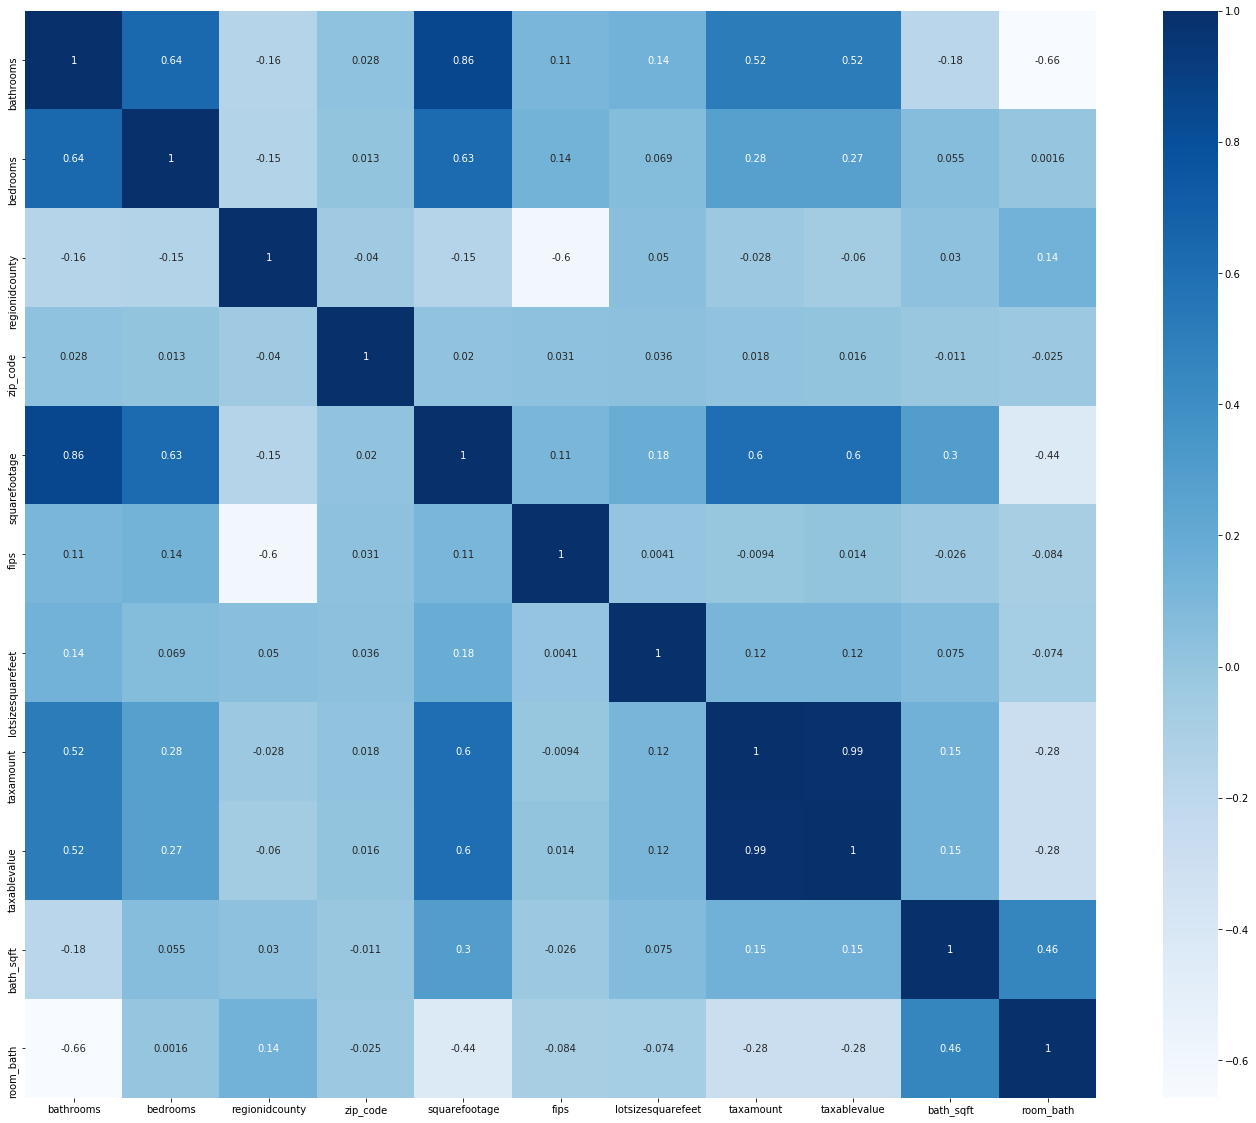

In [27]:
plt.figure(figsize=(24,20))
sns.heatmap(fe.corr(), annot=True, cmap='Blues')

In [30]:
f_selector = SelectKBest(f_regression, k=2)
f_selector = f_selector.fit(X_train_scaled, y_train)

X_train_reduced = f_selector.transform(X_train_scaled)

#boolean mask
f_support = f_selector.get_support()

#kept columns
f_feature = X_train_scaled.iloc[:,f_support].columns.tolist()

X_reduced_scaled = X_train_scaled.iloc[:,f_support]

print('SelectKBest selects:',f_feature)
print(X_train.shape)
print(X_train_reduced.shape)

ValueError: k should be >=0, <= n_features = 1; got 2. Use k='all' to return all features.

In [29]:
lm = LinearRegression()

# 2 features
rfe = RFE(lm, 1)

X_rfe = rfe.fit_transform(X_train_scaled, y_train)                 

mask = rfe.support_                       

X_reduced_scaled_rfe = X_train_scaled.iloc[:,mask] 

rfe_feature = X_reduced_scaled_rfe.columns.tolist() 
print('Recursive Feature Elimination selects:',f_feature)
print(X_train.shape)
print(X_train_reduced.shape)

ValueError: Found array with 1 feature(s) (shape=(8069, 1)) while a minimum of 2 is required.